## Explorer Transportation Data Science Project Jan 3 - Jan 27 2025
#### Analysis Completed by: George Musabandesu

#### Data Source: 
https://data.sfgov.org/Public-Safety/Traffic-Crashes-Resulting-in-Injury/ubvf-ztfx/about_data?utm_source=chatgpt.com

This dataset contains all crashes resulting in an injury in the City of San Francisco. Its a compilation of data from various sources. Fatality year-to-date crash data is obtained from the Office of the Chief Medical Examiner (OME) death records, and only includes those cases that meet the San Francisco Vision Zero Fatality Protocol maintained by the San Francisco Department of Public Health (SFDPH), San Francisco Police Department (SFPD), and San Francisco Municipal Transportation Agency (SFMTA). Injury crash data is obtained from SFPD’s Interim Collision System for 2018 through the current year-to-date, Crossroads Software Traffic Collision Database (CR) for years 2013-2017 and the Statewide Integrated Transportation Record System (SWITRS) maintained by the California Highway Patrol for all years prior to 2013. Collision injury data is queried and aggregated on a quarterly basis. Crashes occurring at complex intersections with multiple roadways are mapped onto a single point and injury and fatality crashes occurring on highways are excluded.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import folium

In [2]:
data = pd.read_csv('Traffic_Crashes_Resulting_in_Injury_20250115.csv')

/var/folders/tv/svl9k8b17dbf_t6w06zb78z40000gn/T/ipykernel_8577/2351936131.py:1: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Traffic_Crashes_Resulting_in_Injury_20250115.csv')


In [3]:
# Looking at the first 5 rows of the dataset
data.head(5)

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,...,data_updated_at,data_loaded_at,analysis_neighborhood,supervisor_district,police_district,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Neighborhoods,SF Find Neighborhoods
0,48523,26031000.0,9760000.0,190484726,37.773153,-122.437266,SFPD-INTERIM DB,CITY STREET,07/04/2019 05:50:00 PM,2019 July 04,...,04/26/2023 12:00:00 AM,01/15/2025 02:34:09 PM,Hayes Valley,5.0,PARK,4.0,11.0,9.0,26.0,26.0
1,18144,25892000.0,4987000.0,130941184,37.769376,-122.430507,SFPD-CROSSROADS,CITY STREET,11/06/2013 07:57:00 AM,2013 November 06,...,04/26/2023 12:00:00 AM,01/15/2025 02:34:09 PM,Hayes Valley,8.0,NORTHERN,7.0,5.0,9.0,28.0,28.0
2,85951,23323000.0,7553000.0,240407262,37.717965,-122.499280,SFPD-INTERIM DB,CITY STREET,06/30/2024 03:30:00 PM,2024 June 30,...,01/15/2025 12:00:00 AM,01/15/2025 02:34:09 PM,Lakeshore,7.0,TARAVAL,10.0,8.0,16.0,43.0,43.0
3,40285,27343000.0,912101.0,3346324,37.758174,-122.476625,SFPD-CROSSROADS,CITY STREET,07/07/2007 03:53:00 AM,2007 July 07,...,04/26/2023 12:00:00 AM,01/15/2025 02:34:09 PM,Inner Sunset,7.0,TARAVAL,10.0,8.0,14.0,44.0,44.0
4,43712,27546000.0,2671000.0,2658927,37.776248,-122.485626,SFPD-CROSSROADS,CITY STREET,05/04/2006 02:30:00 PM,2006 May 04,...,04/26/2023 12:00:00 AM,01/15/2025 02:34:09 PM,Outer Richmond,1.0,RICHMOND,8.0,4.0,29.0,8.0,8.0


In [4]:
# Disabling Scientific notation before using the .describe() function to get summary statistics
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
# Summary statistics
data.describe()

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,tb_latitude,tb_longitude,accident_year,distance,number_killed,number_injured,party_at_fault,supervisor_district,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Neighborhoods,SF Find Neighborhoods
count,61272.00,61250.00,27361.00,61104.00,61104.00,61272.00,61193.00,61269.00,61272.00,55197.00,61029.00,61034.00,61056.00,61039.00,60002.00,60002.00
mean,34821.66,25864431.43,6985391.45,37.77,-122.43,2014.42,56.00,0.01,1.25,1.01,6.08,5.14,6.69,20.63,53.42,53.42
std,23468.46,4941028.31,4080830.58,0.02,0.03,5.71,263.83,0.10,0.70,0.12,2.91,2.98,3.37,12.38,32.75,32.75
min,1.00,20006000.00,100000.00,37.71,-122.51,2005.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,15982.75,23856000.00,3456000.00,37.75,-122.44,2010.00,0.00,0.00,1.00,1.00,4.00,3.00,3.00,9.00,27.00,27.00
50%,31879.50,24934000.00,7304000.00,37.77,-122.42,2014.00,0.00,0.00,1.00,1.00,6.00,4.00,7.00,20.00,46.00,46.00
75%,48419.25,26696000.00,10172000.00,37.78,-122.41,2019.00,51.00,0.00,1.00,1.00,9.00,8.00,10.00,34.00,86.00,86.00
max,87685.00,54366000.00,19999101.00,37.83,-122.36,2024.00,26400.00,3.00,19.00,5.00,11.00,10.00,11.00,41.00,117.00,117.00


unique_id is a unique identifier for each crash.  
Number of persons injured: On everage, each crash has around 1.25 persons injured with the maximum number of injuries at 19  
Number of persons killed: On average, each crash has around 0.01 deaths per crash. The maximum number of deaths in one crash is 3.  
tb_latitude and tb_longitude give the actual location of the collision. There are does not seem to be missing values in this column

In [6]:
# Looking at the number of collisions given weather conditions
data['weather_2'].value_counts()

weather_2
Not Stated                     59334
Raining                          578
Wind                             223
Cloudy                           170
Other                             68
Fog                               51
Fog / Visibility                  10
Snowing                            4
Fog / Visibility: 100 ft           2
Fog / Visibility: 30 ft            2
Other: Sunny                       2
Other: MIST                        2
Other: SUNRISE                     1
Other: FALLING ASH                 1
Other: Light drizzle (rain)        1
Other: SUNNY                       1
Fog / Visibility: 500 ft           1
Other: drizzle                     1
Other: light drizzle               1
Other: Drizzling                   1
Fog / Visibility: 15 ft            1
Other: SUN GLARING                 1
Other: SMOKEY                      1
Other: MISTING                     1
Other: Overcast                    1
Other: Misty                       1
Other: NOT ON SCENE         

In [7]:
# Filtering out rare weather categories
weather_counts = data['weather_2'].value_counts()

# Removing all weather conditions with a value less than 2 occurrences
relevant_weather = weather_counts[weather_counts>2].index
filtered_data = data[data['weather_2'].isin(relevant_weather)]

In [8]:
# Looking at the filterd data
filtered_data.head()

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,...,data_updated_at,data_loaded_at,analysis_neighborhood,supervisor_district,police_district,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Neighborhoods,SF Find Neighborhoods
0,48523,26031000.00,9760000.00,190484726,37.77,-122.44,SFPD-INTERIM DB,CITY STREET,07/04/2019 05:50:00 PM,2019 July 04,...,04/26/2023 12:00:00 AM,01/15/2025 02:34:09 PM,Hayes Valley,5.00,PARK,4.00,11.00,9.00,26.00,26.00
1,18144,25892000.00,4987000.00,130941184,37.77,-122.43,SFPD-CROSSROADS,CITY STREET,11/06/2013 07:57:00 AM,2013 November 06,...,04/26/2023 12:00:00 AM,01/15/2025 02:34:09 PM,Hayes Valley,8.00,NORTHERN,7.00,5.00,9.00,28.00,28.00
2,85951,23323000.00,7553000.00,240407262,37.72,-122.50,SFPD-INTERIM DB,CITY STREET,06/30/2024 03:30:00 PM,2024 June 30,...,01/15/2025 12:00:00 AM,01/15/2025 02:34:09 PM,Lakeshore,7.00,TARAVAL,10.00,8.00,16.00,43.00,43.00
3,40285,27343000.00,912101.00,3346324,37.76,-122.48,SFPD-CROSSROADS,CITY STREET,07/07/2007 03:53:00 AM,2007 July 07,...,04/26/2023 12:00:00 AM,01/15/2025 02:34:09 PM,Inner Sunset,7.00,TARAVAL,10.00,8.00,14.00,44.00,44.00
4,43712,27546000.00,2671000.00,2658927,37.78,-122.49,SFPD-CROSSROADS,CITY STREET,05/04/2006 02:30:00 PM,2006 May 04,...,04/26/2023 12:00:00 AM,01/15/2025 02:34:09 PM,Outer Richmond,1.00,RICHMOND,8.00,4.00,29.00,8.00,8.00


/var/folders/tv/svl9k8b17dbf_t6w06zb78z40000gn/T/ipykernel_8577/3579333999.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top_weather_factors.index, y = top_weather_factors.values, palette = 'magma')


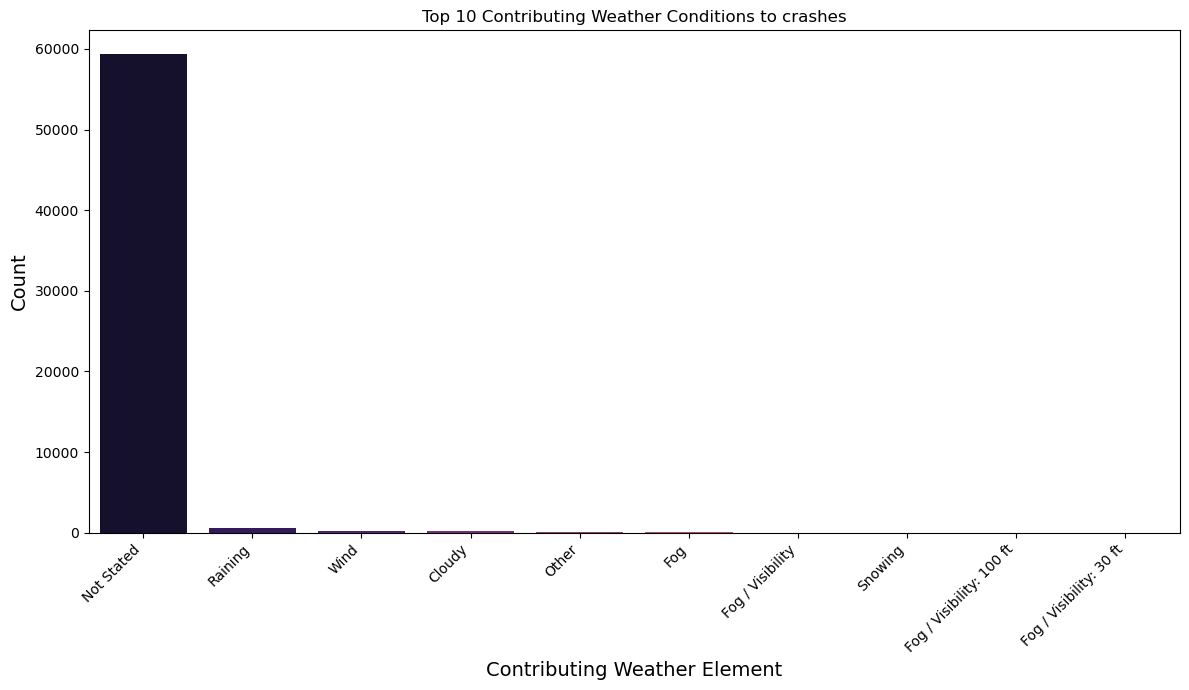

In [9]:
# Bar chart of top weather factors
top_weather_factors = data['weather_2'].value_counts().head(10)

plt.figure(figsize = (12,7))
sns.barplot(x = top_weather_factors.index, y = top_weather_factors.values, palette = 'magma')
plt.title("Top 10 Contributing Weather Conditions to crashes")
plt.xlabel("Contributing Weather Element", fontsize=14)
plt.ylabel("Count", fontsize = 14)
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

In [10]:
# Looking at number of collisions and prevailing weather conditions
filtered_data['weather_2'].value_counts()

weather_2
Not Stated          59334
Raining               578
Wind                  223
Cloudy                170
Other                  68
Fog                    51
Fog / Visibility       10
Snowing                 4
Name: count, dtype: int64

A huge portion of collisions do not have weather data included as can be observed from the bar chart and the value counts above. However, rain, wind, and cloudy weather conditions show high collision numbers compared to other weather conditions

/var/folders/tv/svl9k8b17dbf_t6w06zb78z40000gn/T/ipykernel_8577/874984313.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top_weather_factors.index, y = top_weather_factors.values, palette = 'magma')


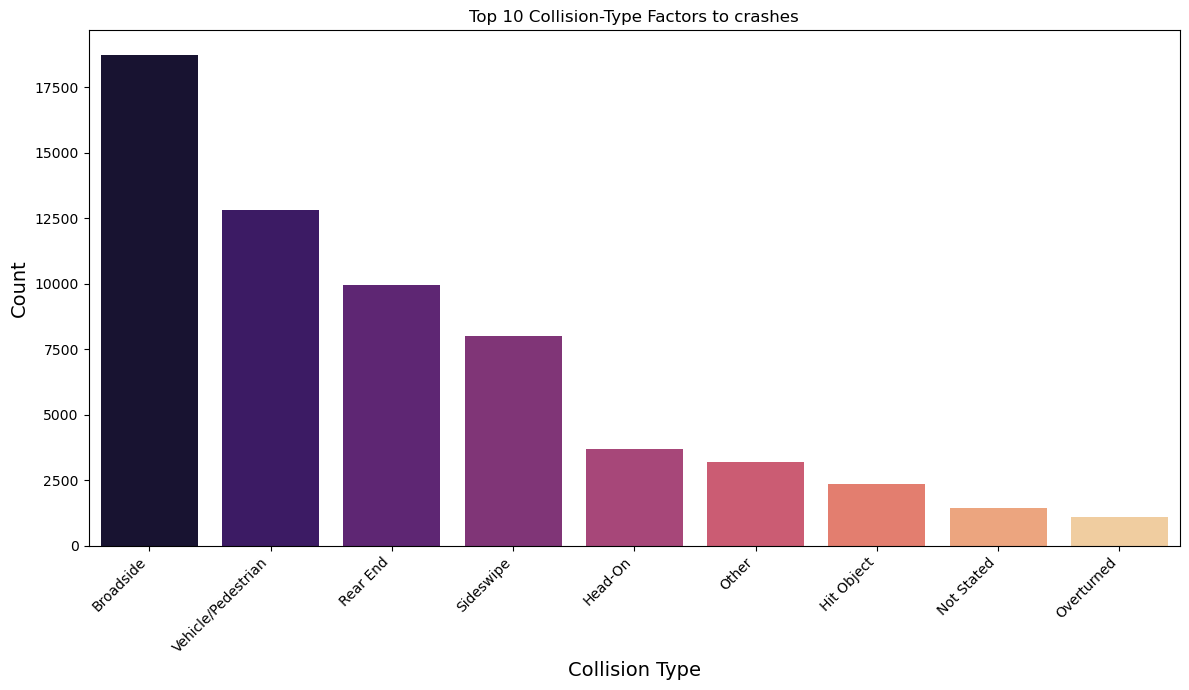

In [11]:
# Bar chart of top 10 Collision Factors factors
top_weather_factors = data['type_of_collision'].value_counts().head(10)

plt.figure(figsize = (12,7))
sns.barplot(x = top_weather_factors.index, y = top_weather_factors.values, palette = 'magma')
plt.title("Top 10 Collision-Type Factors to crashes")
plt.xlabel("Collision Type", fontsize=14)
plt.ylabel("Count", fontsize = 14)
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

A large portion of the collision types falls under the Broadside category, which means the front side of a vehicle hits the side of another vehicle. (t-bone collision) 
The other second most collision type involves pedestrians. Rear ends and Sideswipe come in as the third and fourth most collision types.

In [12]:
# Looking at the values in the categories under type of collision
data['type_of_collision'].value_counts()

type_of_collision
Broadside             18743
Vehicle/Pedestrian    12827
Rear End               9947
Sideswipe              8007
Head-On                3682
Other                  3196
Hit Object             2333
Not Stated             1431
Overturned             1106
Name: count, dtype: int64

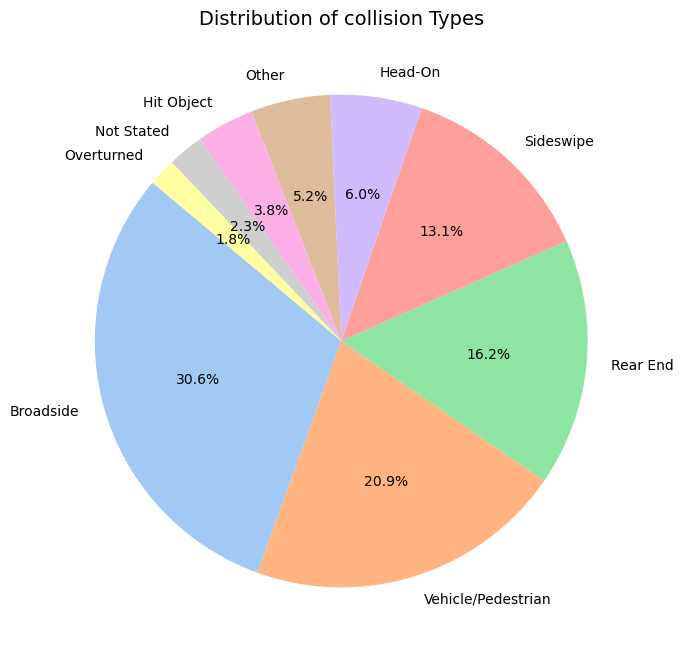

In [13]:
#Pie Chart
collision_types = data['type_of_collision'].value_counts()
plt.figure(figsize = (8,8))
collision_types.plot(kind = 'pie', autopct = '%1.1f%%', startangle = 140,
                     colors = sns.color_palette('pastel'),)
plt.title('Distribution of collision Types', fontsize=14)
plt.ylabel('') # hide the y axis
plt.show()

This pie chart provides another visual summary of the types of collisions

/var/folders/tv/svl9k8b17dbf_t6w06zb78z40000gn/T/ipykernel_8577/2143848051.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = pedestrian_action.index, y = pedestrian_action.values, palette = 'cividis')


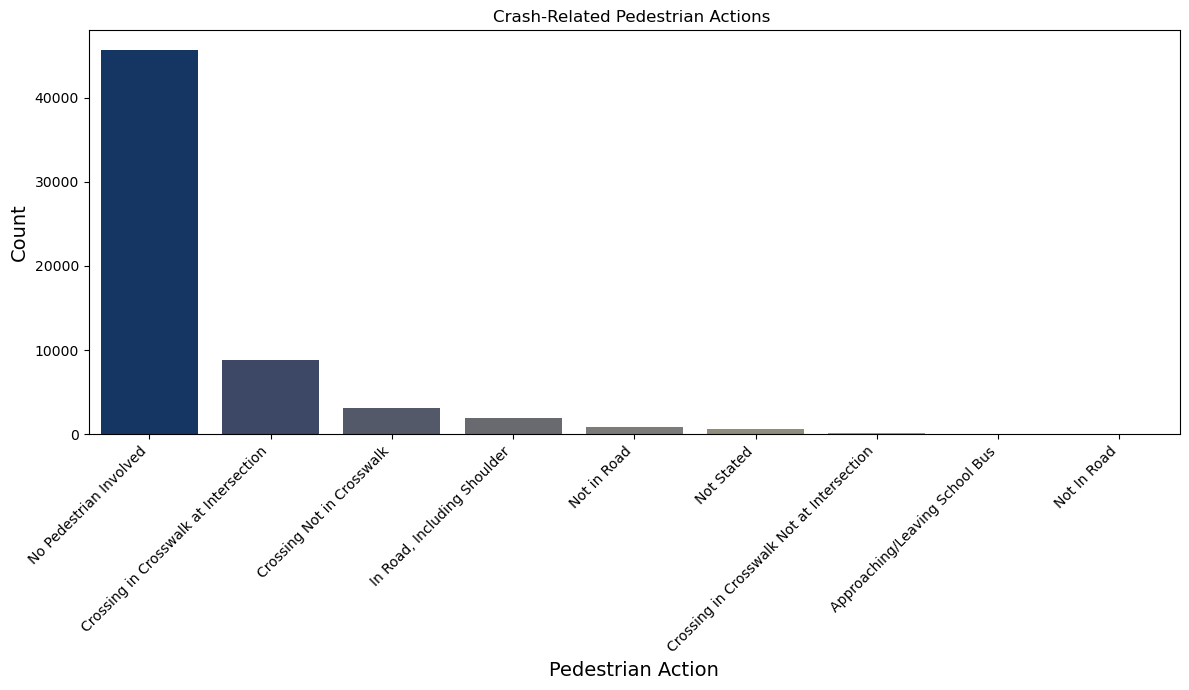

In [14]:
# Pedestrian actions during crash
pedestrian_action = data['ped_action'].value_counts().head(10)

plt.figure(figsize = (12,7))
sns.barplot(x = pedestrian_action.index, y = pedestrian_action.values, palette = 'cividis')
plt.title("Crash-Related Pedestrian Actions ")
plt.xlabel("Pedestrian Action", fontsize=14)
plt.ylabel("Count", fontsize = 14)
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

A large portion of collisions do not involve pedestrians (about 75%). Crosswalks at intersections show the most amount of pedestrian-involved collisions.

In [15]:
# #Pie Chart - Pedestrian actions during crash
# collision_types = data['ped_action'].value_counts()
# plt.figure(figsize = (8,8))
# collision_types.plot(kind = 'pie', autopct = '%1.1f%%', startangle = 140,
#                      colors = sns.color_palette('pastel'), labeldistance = 1.2, pctdistance = 0.8)
# plt.title('Distribution of Pedestrian Actions during Crash', fontsize=14)
# plt.ylabel('') # hide the y axis
# plt.show()

/var/folders/tv/svl9k8b17dbf_t6w06zb78z40000gn/T/ipykernel_8577/4165177599.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top_weather_factors.index, y = top_weather_factors.values, palette = 'magma')


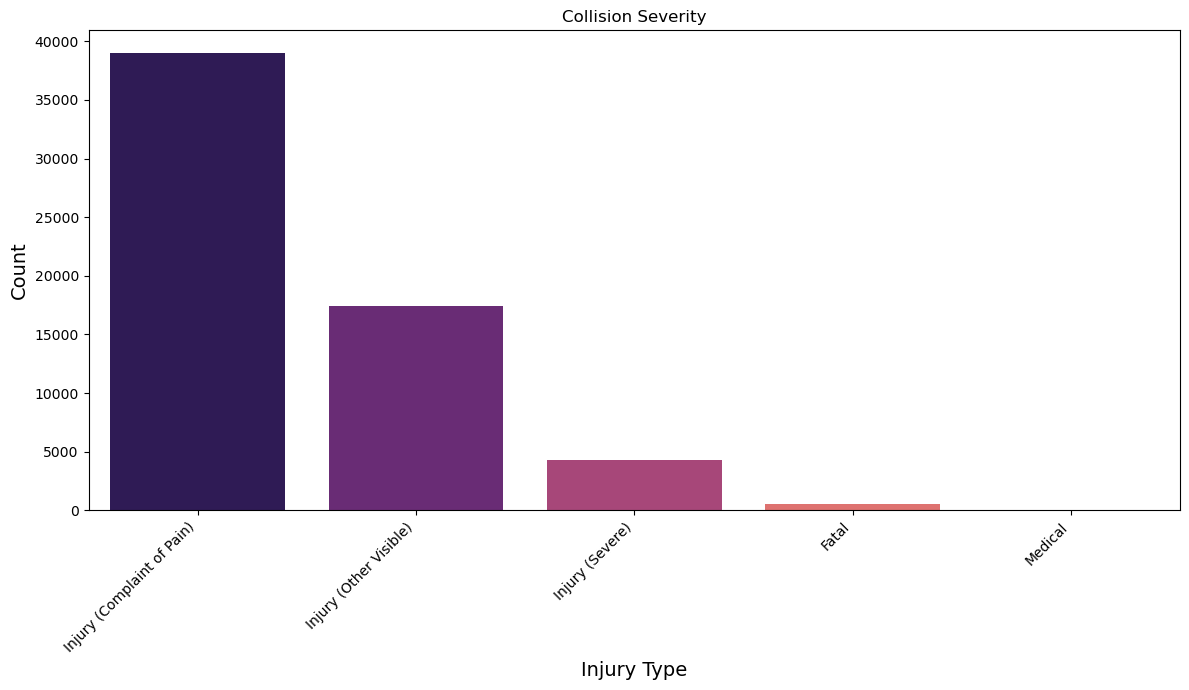

In [16]:
# Bar chart of Collision Severity
top_weather_factors = data['collision_severity'].value_counts().head(10)

plt.figure(figsize = (12,7))
sns.barplot(x = top_weather_factors.index, y = top_weather_factors.values, palette = 'magma')
plt.title("Collision Severity")
plt.xlabel("Injury Type", fontsize=14)
plt.ylabel("Count", fontsize = 14)
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

In [17]:
# Looking at the values in each collision category
data['collision_severity'].value_counts()

collision_severity
Injury (Complaint of Pain)    38983
Injury (Other Visible)        17416
Injury (Severe)                4299
Fatal                           572
Medical                           2
Name: count, dtype: int64

In [18]:
# Calculate value counts with percentages
severity_percentage = data['collision_severity'].value_counts(normalize=True) * 100

# Display the counts and percentages
severity_percentage_df = severity_percentage.reset_index()
severity_percentage_df.columns = ['Collision Severity', 'Percentage (%)']

print(severity_percentage_df)

           Collision Severity  Percentage (%)
0  Injury (Complaint of Pain)           63.62
1      Injury (Other Visible)           28.42
2             Injury (Severe)            7.02
3                       Fatal            0.93
4                     Medical            0.00


The majority of the parties involved in the collisions sustained some sort of injury. Some of those collisions reported severe injuries and a few others were fatal.

In [19]:
# # Scatter plots
# # Plot collision severity vs. weather conditions
# plt.figure(figsize= (10,6))
# sns.scatterplot(x=data['hour_of_day'], y=data['collision_severity'], 
#                 hue = filtered_data['weather_2'], palette='magma', 
#                 alpha = 0.7)
# plt.title('Collision Severity by Hour of Day and Weather', fontsize=14)
# plt.xlabel('Hour of Day', fontsize=14)
# plt.ylabel('Collision Severity', fontsize=14)
# plt.legend(title='Weather')
# plt.show()

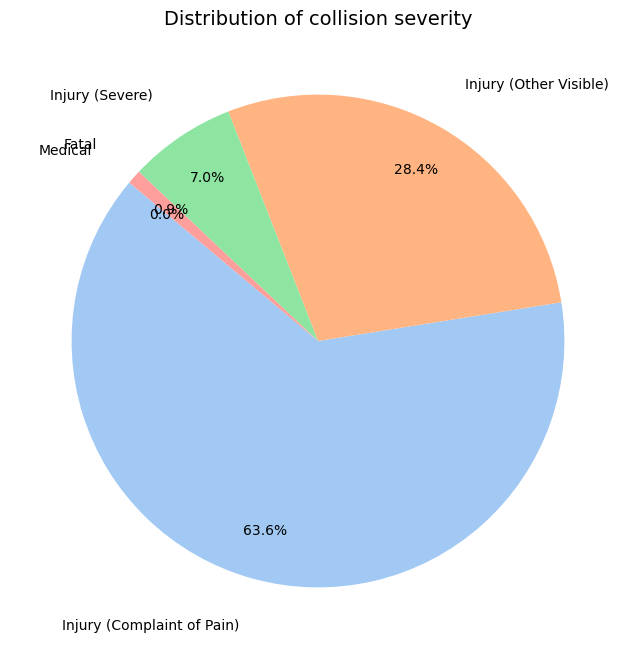

In [20]:
#Pie Chart - Collision severity
collision_types = data['collision_severity'].value_counts()
plt.figure(figsize = (8,8))
collision_types.plot(kind = 'pie', autopct = '%1.1f%%', startangle = 140,
                     colors = sns.color_palette('pastel'),labeldistance = 1.2, pctdistance = 0.8)
plt.title('Distribution of collision severity', fontsize=14)
plt.ylabel('') # hide the y axis
plt.show()

Regarding the severity of injury from the collisions, only about 7% of the collision were severe and about 0.9% fatal.

In [21]:
# A sum of all missing values per column
missing_values = data.isnull().sum()

# Turn missing value counts into percentages
missing_values_percentage = (missing_values/len(data))*100

# Return counts and percentages of missing values in each column
missing_data = pd.DataFrame({'missing Values': missing_values, 'Percentage (%)': missing_values_percentage})
missing_data.sort_values(by = 'Percentage (%)', ascending = False)

,missing Values,Percentage (%)
cnn_sgmt_fkey,33911,55.35
control_device,20651,33.70
reporting_district,6510,10.62
party_at_fault,6075,9.91
beat_number,4677,7.63
...,...,...
ped_action,0,0.00
road_surface,0,0.00
road_cond_1,0,0.00
lighting,0,0.00


Two columns with the highest percentage of missing values are cnn_sgmt_fkey and control_device. These will not be used in the rest of the project

#### Time Series Analysis

In [22]:
# Convert the date and time column to datetime
data['collision_datetime'] = pd.to_datetime(data['collision_datetime'], format = '%m/%d/%Y %I:%M:%S %p')
print(data['collision_datetime'].head())

0   2019-07-04 17:50:00
1   2013-11-06 07:57:00
2   2024-06-30 15:30:00
3   2007-07-07 03:53:00
4   2006-05-04 14:30:00
Name: collision_datetime, dtype: datetime64[ns]


In [23]:
# Extract Hour and month
data['hour_of_day'] = data['collision_datetime'].dt.hour
data['month'] = data['collision_datetime'].dt.month_name()

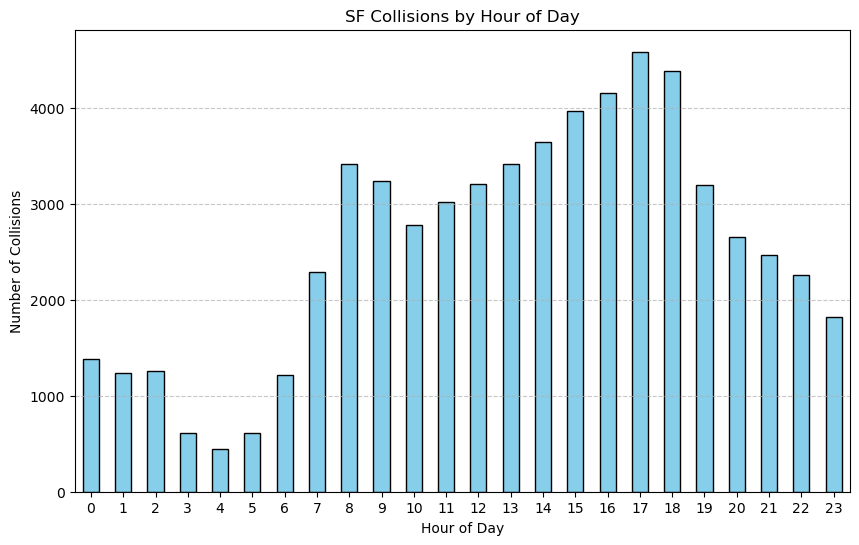

In [24]:
# Grouping the data to calculate the number of collisions by hour and by month
hourly_collisions = data.groupby('hour_of_day').size()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
hourly_collisions.plot(kind = 'bar', color = 'skyblue', edgecolor = 'black')
plt.title('SF Collisions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Collisions')
plt.xticks(rotation = 0)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

From 5am to 5pm there is an increase in the number of collisions during the day overall. The numbers slow down after 5pm. This can most likely be attributed to commute traffic at the start of the workday and the end of it.

/var/folders/tv/svl9k8b17dbf_t6w06zb78z40000gn/T/ipykernel_8577/4039516681.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_collisions = data.groupby('month').size()


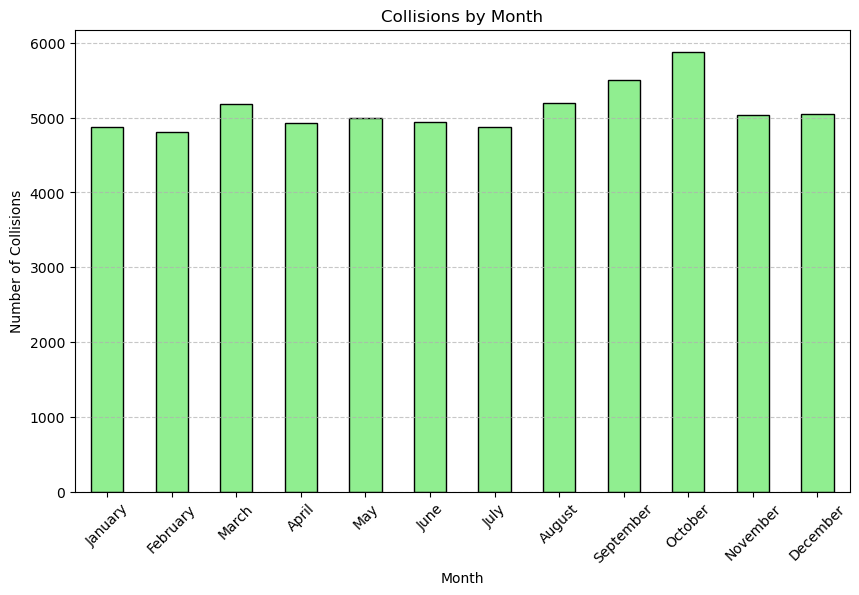

In [25]:
# Grouping the data to calculate the number of collisions by month

# Order months correctly
data['month'] = pd.Categorical(data['month'], categories = ['January', 'February', 'March', 'April', 
                                                            'May', 'June', 'July','August', 'September', 
                                                            'October', 'November', 'December'],
                               ordered = True)

monthly_collisions = data.groupby('month').size()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
monthly_collisions.plot(kind = 'bar', color = 'lightgreen', edgecolor = 'black')
plt.title('Collisions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Collisions')
plt.xticks(rotation = 45)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

Looking at collisions by month, October shows a slighlty higher number of collisions overall. This could be due to increased traffic for people visiting the city as this is a time of the year that has warm weather.

/var/folders/tv/svl9k8b17dbf_t6w06zb78z40000gn/T/ipykernel_8577/1036175451.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  collisions_monthly = data.set_index('collision_datetime').resample('M').size()


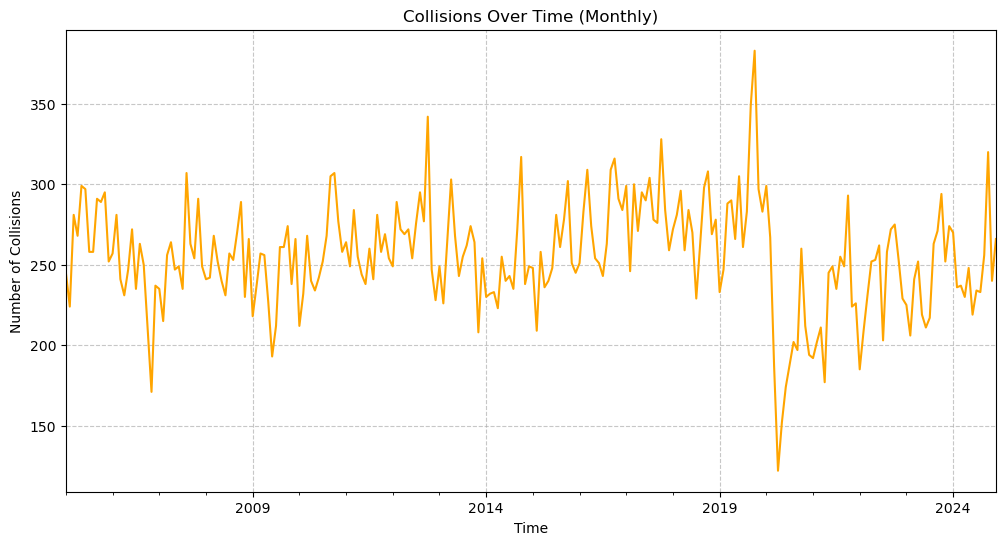

In [26]:
# Time series showing monthly collisions from 2009 to 2024 for SF
collisions_monthly = data.set_index('collision_datetime').resample('M').size()

# Plotting
plt.figure(figsize=(12, 6))
collisions_monthly.plot(color='orange')
plt.title('Collisions Over Time (Monthly)')
plt.xlabel('Time')
plt.ylabel('Number of Collisions')
plt.grid(linestyle='--', alpha=0.7)
plt.show()


Collisions had a sharp declined in 2020 most likely due to the COVID-19 pandemic. The numbers rebounded afterwards and appear to match the pre-pandemic levels

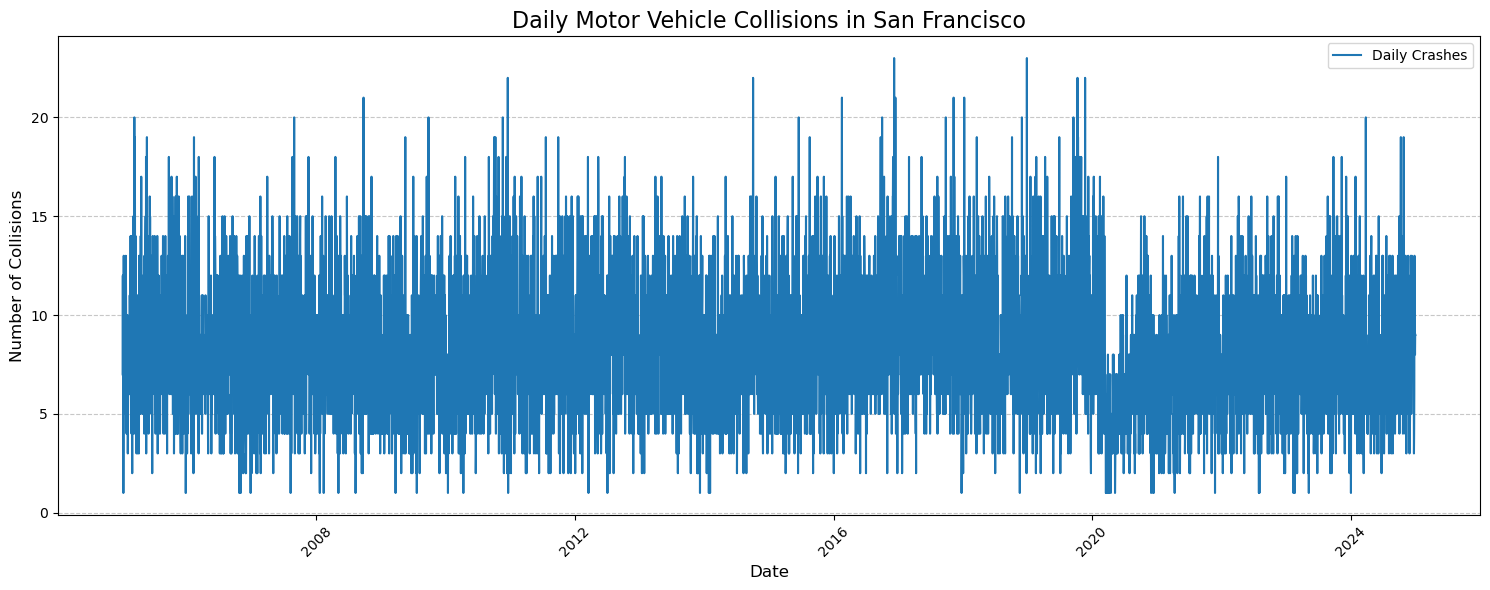

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'collision_datetime' is in datetime format
data['collision_datetime'] = pd.to_datetime(data['collision_datetime'])

# Extract the date part from 'collision_datetime' for grouping
data['collision_date_only'] = data['collision_datetime'].dt.date

# Count the number of crashes per day
daily_crashes = data.groupby('collision_date_only').size()

# Set plot style
plt.figure(figsize=(15, 6))
plt.plot(daily_crashes, label="Daily Crashes")
plt.title('Daily Motor Vehicle Collisions in San Francisco', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Collisions', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

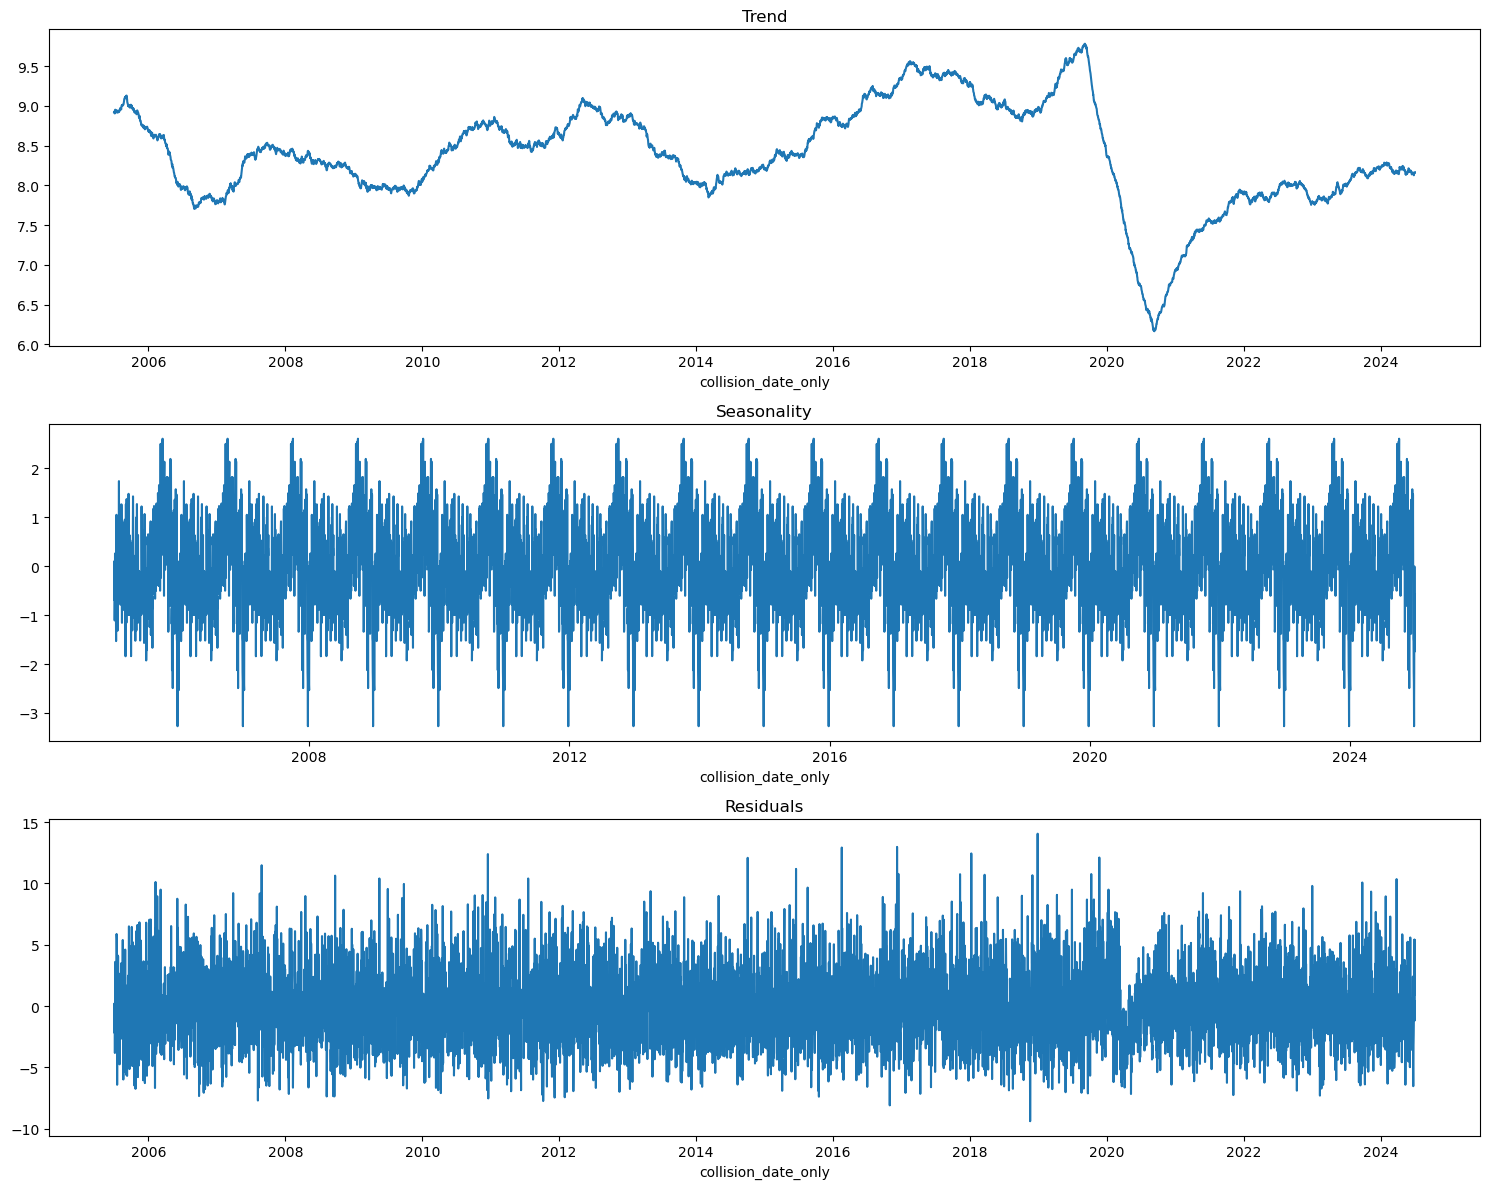

In [28]:

# Decompose the time series
decompose = seasonal_decompose(daily_crashes, model = 'additive', period = 365)

# Plot of decomposed time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,12))
decompose.trend.plot(ax = ax1)
ax1.set_title('Trend')

decompose.seasonal.plot(ax = ax2)
ax2.set_title('Seasonality')

decompose.resid.plot(ax = ax3)
ax3.set_title('Residuals')
plt.tight_layout()
plt.show()

In [29]:
# Adding a column to capture weekly collisions
data['week_of_day'] = data['collision_datetime'].dt.day_name()

#### Heatmaps and Geospatial maps

In [30]:
#Heatmaps - Timebased heatmap showing collisions by hour of the day and day of the week
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_info = data.groupby(['day_of_week', 'hour_of_day']).size().unstack()

# Reorder days of the week
heatmap_info = heatmap_info.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                                    'Saturday', 'Sunday'])

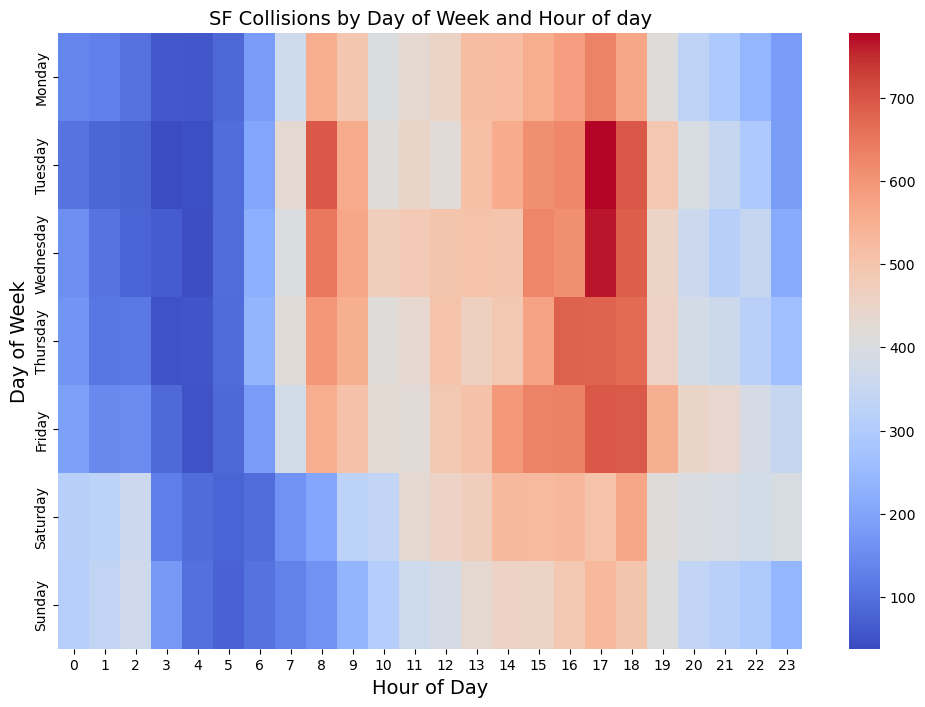

In [31]:
plt.figure(figsize = (12,8))
sns.heatmap(heatmap_info, cmap = 'coolwarm', annot=False)
plt.title('SF Collisions by Day of Week and Hour of day', fontsize = 14)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Day of Week', fontsize=14)
plt.show()

Monday through Friday show increased collisions aroud 8 am and starting at around 3pm to 7 pm. Friday shows more collisions past 7pm. This maybe due to increased travel going into the weekend.   
For Saturday, most collisions occur around 11am to midnight. Sunday shows a reduced collision occurence from 1pm to 7pm

#### Geospatial Maps

In [32]:
# Drop rows with missing latitude and longitude values
data = data.dropna(subset = ['tb_latitude', 'tb_longitude'])

In [33]:
# Creating a heatmap using latitude and longitude variables to see where the most crashes are occuring
from folium.plugins import HeatMap

# Base map
m = folium.Map(location =[37.7749, -122.4194], zoom_start=10) # Centered around SF

# Create a heatmap
sf_heatmap = [[row['tb_latitude'], row['tb_longitude']] for index, row in data.iterrows()]
HeatMap(sf_heatmap, radius = 15, max_zoom=15).add_to(m)
m.save('SF_heatmap.html')

The heatmap shows that the skewed intersection of octavia boulevard and market street recorded a high number of collisions. Market street and 5th and Market street and 7th intersections also shows increased collisions. This part of SF has a lot of vehicular and pedestrian activity so

In [34]:
# Severity Mapping
severity_data = data.sample(n=1000, random_state = 42)

# Base Map
m_severity = folium.Map(location = [37.7749, -122.4194], zoom_start=10)

# Add crashes to the map with color coding and shape coding based on severity
for index, row in severity_data.iterrows():
    if row['number_killed']> 0:
        color = "red" # Fatalities
        
        folium.features.RegularPolygonMarker(
        location=[row['tb_latitude'], row['tb_longitude']],
        number_of_sides =3,
        radius = 5,
        gradient = False,
        color=color
        ).add_to(m_severity)
    elif row['number_injured']>0:
        color = "purple" # Injuries
        folium.CircleMarker(
        location = [row['tb_latitude'], row['tb_longitude']],
        radius = 5,
        color=color,
        fill=True,
        fill_color = color
        ).add_to(m_severity)
    else:
        color = "black" # No injuries or fatalities
        folium.features.RegularPolygonMarker(
        location= [row['tb_latitude'], row['tb_longitude']],
        number_of_sides=4,
        radius=5,
        gradient = False,
        color=color,
        fill=True,
        fill_color=color
        ).add_to(m_severity)
        
m_severity.save("SF_severity.html")

From the results of the severity map, the north east of SF has the most concentration of collisions. Going northbound on market street, passed its intersection with 11th street, most intersections have a reported collision, with 7th street showing a fatality. There is only a handful of collisions that did not result in any injuries. Most collisions reported some sort of injury.